In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet

starry.config.quiet = True
np.random.seed(1)

In [2]:
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)
A.map[1] = 0.4
A.map[2] = 0.2

In [3]:
# These are the parameters we're going to try to infer
log_amp_true = -3.0
offset_true = 30.0

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp_true, inc=90.0, obl=0.0),
    m=0.0,
    r=0.1,
    inc=90.0,
    prot=1.0,
    porb=1.0,
)
b.map[1, 0] = 0.5
b.theta0 = 180.0 + offset_true

In [4]:
sys = starry.System(A, b)

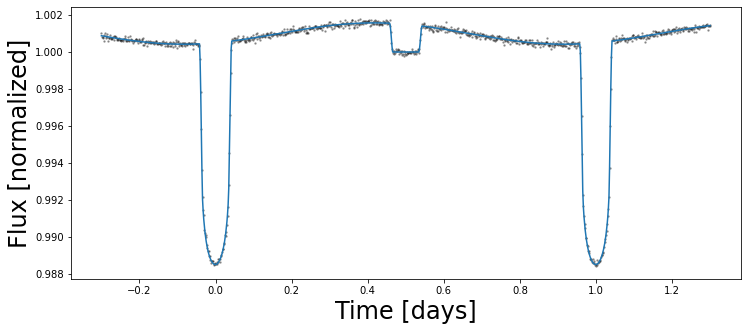

In [5]:
t = np.linspace(-0.3, 1.3, 1000)
flux_true = sys.flux(t).eval()
ferr = 1e-4
flux = flux_true + ferr * np.random.randn(len(t))
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, flux_true)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [6]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0, inc=90.0, obl=0.0), m=1.0, r=1.0, prot=1.0
    )
    A.map[1] = 0.4
    A.map[2] = 0.2

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp, inc=90.0, obl=0.0),
        m=0.0,
        r=0.1,
        prot=1.0,
        porb=1.0,
    )
    b.map[1, 0] = 0.5
    b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(t))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=ferr, observed=flux)

In [7]:
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [log_amp, offset]


message: Desired error not necessarily achieved due to precision loss.
logp: -26221.397786434205 -> 7803.390365698352


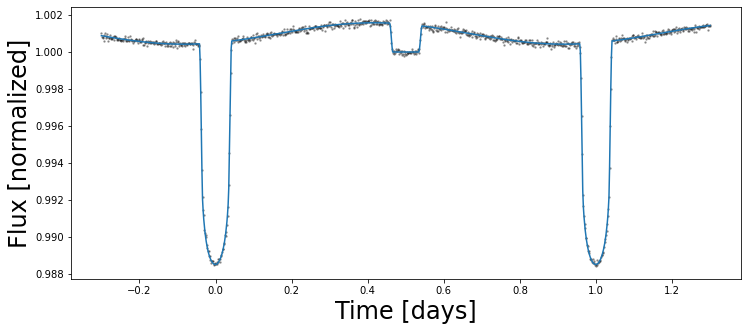

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [9]:
print("offset:", map_soln["offset"])
print("log_amp:", map_soln["log_amp"])

offset: 30.05203148547303
log_amp: -2.998333491712644


In [10]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

/Users/japa6985/opt/anaconda3/envs/starry/lib/python3.9/site-packages/deprecat-2.1.1-py3.9.egg/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (4 chains in 1 job)
NUTS: [log_amp, offset]


/Users/japa6985/opt/anaconda3/envs/starry/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 59 seconds.
The acceptance probability does not match the target. It is 0.9598605856234323, but should be close to 0.9. Try to increase the number of tuning steps.


In [11]:
pm.summary(trace, var_names=["log_amp", "offset"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/japa6985/opt/anaconda3/envs/starry/lib/python3.9/site-packages/arviz-0.12.1-py3.9.egg/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_amp,-2.998,0.001,-3.001,-2.996,0.000,0.00,1606.0,1185.0,1.0
offset,30.049,0.466,29.232,30.952,0.014,0.01,1179.0,1101.0,1.0


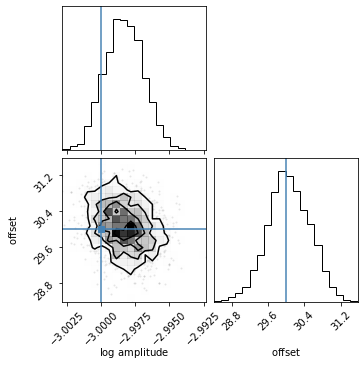

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["log_amp", "offset"])
corner.corner(
    np.array(samples),
    truths=[log_amp_true, offset_true],
    labels=[r"$\log\,\mathrm{amplitude}$", r"$\mathrm{offset}$"],
);